Chest X-ray Abnormality Classifier

Goal: Classify X-rays as “Normal” vs “Abnormal (e.g., pneumonia, effusion, fibrosis).”

Dataset: NIH Chest X-ray 14 (on Kaggle)

Skills: Image preprocessing, binary classification, Grad-CAM visualization

# 1. Setup & Environment

1. Install required packages (torch, torchvision, matplotlib, tqdm).

2. Set seeds for reproducibility.

3. Note GPU availability and batch-size guidance (detect GPU and adapt batch size).

In [1]:
import torch
from torch import nn

import torchvision

import numpy as np

from pathlib import Path 

import pandas as pd 

import random 

import matplotlib.pyplot as plt 
from PIL import Image, UnidentifiedImageError 

import os 

from collections import Counter 

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 
    
import monai
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, RandFlip, RandRotate, ToTensor 

import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

# 2. Collect Data 

Download the dataset from Kaggle. 

In [3]:
import kagglehub

def download_data(dataset: str):
    # Download latest version
    path = kagglehub.dataset_download(dataset)

    print("Path to dataset files:", path)

dataset = "nih-chest-xrays/data"
# download_data(dataset)

In [4]:
# Save data to a csv and show the first five rows to understand the data
path_to_data_entry_csv = Path(r"C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\Data_Entry_2017.csv")
df = pd.read_csv(path_to_data_entry_csv)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


# 3. Explore the Data 

Use the different image folders, select the correct image folder, pick a random row from the ground truth csv, view the image with the label from the csv 

## 3.1 Create a function to read an image path and return the full path to the image.  After that, write a separate function that takes those image paths and plots an image using the image index from the data frame as the title.

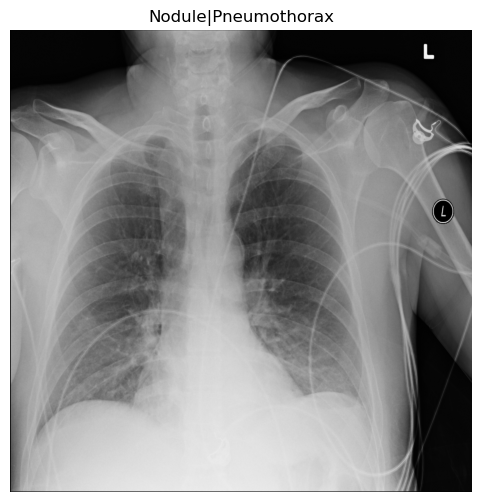

In [5]:
ROOT = Path(r"C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data")

def find_image_path(filename, root=ROOT, n_folders=12):
    """Return full Path to filename by searching images_001 .. images_00{n_folders}.
    
       Args: 
        filename: The filename itself (str)
        root: The path to the file
        n_folders: The number of folders with data in it 
        
       Returns:
        The full path with the filename appended to the root. """
    for i in range(1, n_folders + 1):
        folder = root / f"images_{i:03d}" / "images"
        path = folder / filename
        if path.exists():
            return path
    return None

def plot_random_xray(df, root=ROOT, n_folders=12):
    """Pick a random row from df, load the image safely and plot with ground-truth title. 
        
       Args: 
        df: The dataframe itself 
        root: The path to the file 
        n_folders: The number of folders with data in it 
        
       Returns: 
        Nothing.  Plots the random image."""
    # Use sample to grab a random row and iloc[0] to grab the content of the row
    row = df.sample(1).iloc[0]
    filename = row["Image Index"]
    label = row["Finding Labels"] 

    path = find_image_path(filename, root=root, n_folders=n_folders)
    if path is None:
        raise FileNotFoundError(f"Could not find image {filename} in {root}")

    try:
        with Image.open(path) as img:
            # PIL.Image.open returns a file-like object; use copy() if you plan to keep it after closing
            img = img.convert("L")  # ensure grayscale
            plt.figure(figsize=(6, 6))
            plt.imshow(img, cmap="gray")
            plt.title(label)
            plt.axis("off")
            plt.show()
    except UnidentifiedImageError:
        print(f"Image {path} appears to be corrupted or is not a supported image.")
    except Exception as e:
        print(f"Unexpected error opening {path}: {e}")

# usage
plot_random_xray(df) 

## 3.2 Check for Corrupted Images

In [6]:
root = Path(r"C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data")

def check_for_corrupted_images(root):
    """Check data folders to see if any image is corrupted.  If it is, note it so it is not included in the training to avoid downstream errors. 
    
       Args: 
        root: The directory one level above the data folders. 
         
       Returns: 
        corrupted: A list containing all corrupted images"""
    corrupted = []
    
    # Write a loop to loop through all image folders: images_001, images_002, images_003, ... images_012
    for i in range(1, 13):
        folder = root / f"images_{i:03d}" / "images"
        print(f"Checking folder: {folder}")
        
        for img_path in folder.glob("*.png"):
            try:
                with Image.open(img_path) as img:
                    img.verify()
                with Image.open(img_path) as img:
                    img.load()
                
            except Exception as e:
                corrupted.append((img_path, str(e)))
    return corrupted

corrupted_files = check_for_corrupted_images(root)

print("\n------ SUMMARY -------")
print(f"Total corrupted images: {len(corrupted_files)}")
for path, err in corrupted_files: 
    print(f"{path} - Error: {err}") 

Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_001\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_002\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_003\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_004\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_005\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_006\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_007\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_008\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_009\images
Checking folder: C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data\images_010\images
Checking folder: C:\

## 3.3 Check for label distribution to see where class imbalances lay 

### 3.3.1 Label distribuition - Understand the overall class distribution

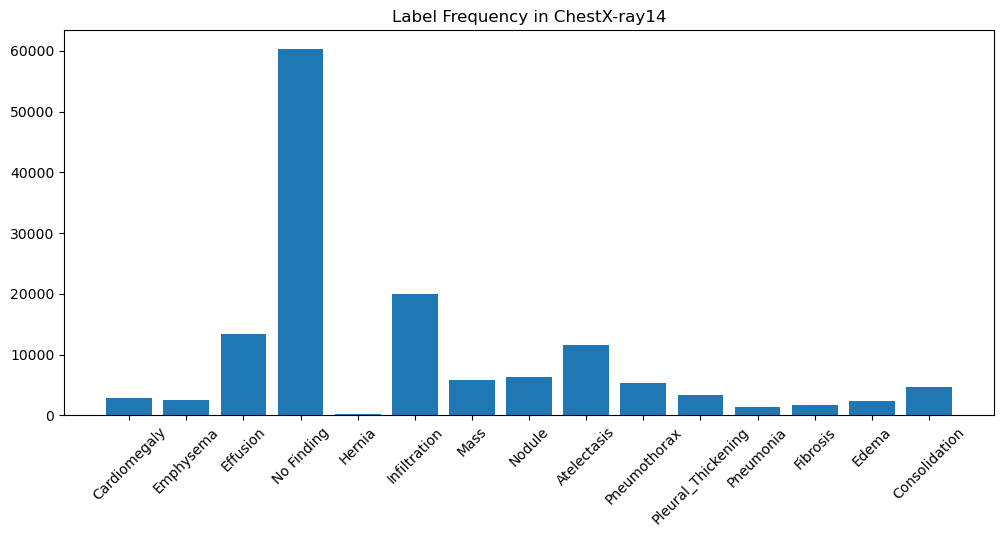

In [6]:
all_labels = Counter()

# Loop through the finding labels to see which labels appear and how many times
for labels in df["Finding Labels"]:
    for label in labels.split("|"):
        all_labels[label] += 1
        
        
# Make a quick bar plot to visualize the distribution
plt.figure(figsize = (12, 5))
plt.bar(all_labels.keys(), all_labels.values())
plt.xticks(rotation = 45)
plt.title("Label Frequency in ChestX-ray14") 
plt.show()

* Note: There is a clear imbalance across the entire dataset, particulary for no findings.  Simply splitting the dataset may lead to improper training.

In [7]:
# We can see based on the values, how skewed it is above.  In a raw number view, we can see below that it is also clearly favoring no finding.
total = sum(all_labels.values())
class_weights = {label: total/count for label, count in all_labels.items()}

class_weights

{'Cardiomegaly': 50.985951008645536,
 'Emphysema': 56.25476947535771,
 'Effusion': 10.628294660959675,
 'No Finding': 2.3448418680936367,
 'Hernia': 623.5110132158591,
 'Infiltration': 7.114557152910425,
 'Mass': 24.478900034590108,
 'Nodule': 22.356183857210553,
 'Atelectasis': 12.244744355048015,
 'Pneumothorax': 26.695020746887966,
 'Pleural_Thickening': 41.81299852289513,
 'Pneumonia': 98.9077568134172,
 'Fibrosis': 83.94839857651246,
 'Edema': 61.45766391663048,
 'Consolidation': 30.327190914934647}

In [8]:
# Make the label columns 
label_columns = [
    "Atelectasis",
    "Cardiomegaly",
    "Effusion",
    "Infiltration",
    "Mass",
    "Nodule",
    "Pneumonia",
    "Pneumothorax",
    "Consolidation",
    "Edema",
    "Emphysema",
    "Fibrosis",
    "Pleural_Thickening",
    "Hernia"
]

def has_label(row, label):
    """Determine if every row in the dataframe has a label. 
    
       Args: 
        row: The row in the dataframe to verify 
        label: The label applied if one is applied.
        
       Returns: 
        A list of labels as integers"""
    return int(label in row["Finding Labels"].split("|"))

for label in label_columns:
    df[label] = df.apply(lambda row: has_label(row, label), axis=1)
    
y = df[label_columns].values

# Lets see another way to visualize the frequency of each class 
class_counts = y.sum(axis = 0)
for name, count in zip(label_columns, class_counts):
    print(f"{name:20s} {count}")

Atelectasis          11559
Cardiomegaly         2776
Effusion             13317
Infiltration         19894
Mass                 5782
Nodule               6331
Pneumonia            1431
Pneumothorax         5302
Consolidation        4667
Edema                2303
Emphysema            2516
Fibrosis             1686
Pleural_Thickening   3385
Hernia               227


In [9]:
# Use MultilabelStratifiedKFold to split the data as evenly as possible.  This is a library from scikit learn and will help us preserve the percentage of samples in each class for balanced training and testing.
mskf = MultilabelStratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

train_idx, val_idx = next(mskf.split(df, y)) 
print(f"Train idx: {train_idx} | Val idx: {val_idx}")

# Make training and testing dataframes
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

Train idx: [     0      1      2 ... 112115 112117 112118] | Val idx: [     3     22     35 ... 112107 112116 112119]


In [10]:
# Lets see if the distribution is maintained
print(train_df[label_columns].sum())
print(val_df[label_columns].sum())


Atelectasis            9248
Cardiomegaly           2221
Effusion              10654
Infiltration          15916
Mass                   4625
Nodule                 5065
Pneumonia              1145
Pneumothorax           4241
Consolidation          3734
Edema                  1842
Emphysema              2013
Fibrosis               1348
Pleural_Thickening     2708
Hernia                  181
dtype: int64
Atelectasis           2311
Cardiomegaly           555
Effusion              2663
Infiltration          3978
Mass                  1157
Nodule                1266
Pneumonia              286
Pneumothorax          1061
Consolidation          933
Edema                  461
Emphysema              503
Fibrosis               338
Pleural_Thickening     677
Hernia                  46
dtype: int64


In [11]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,1
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1


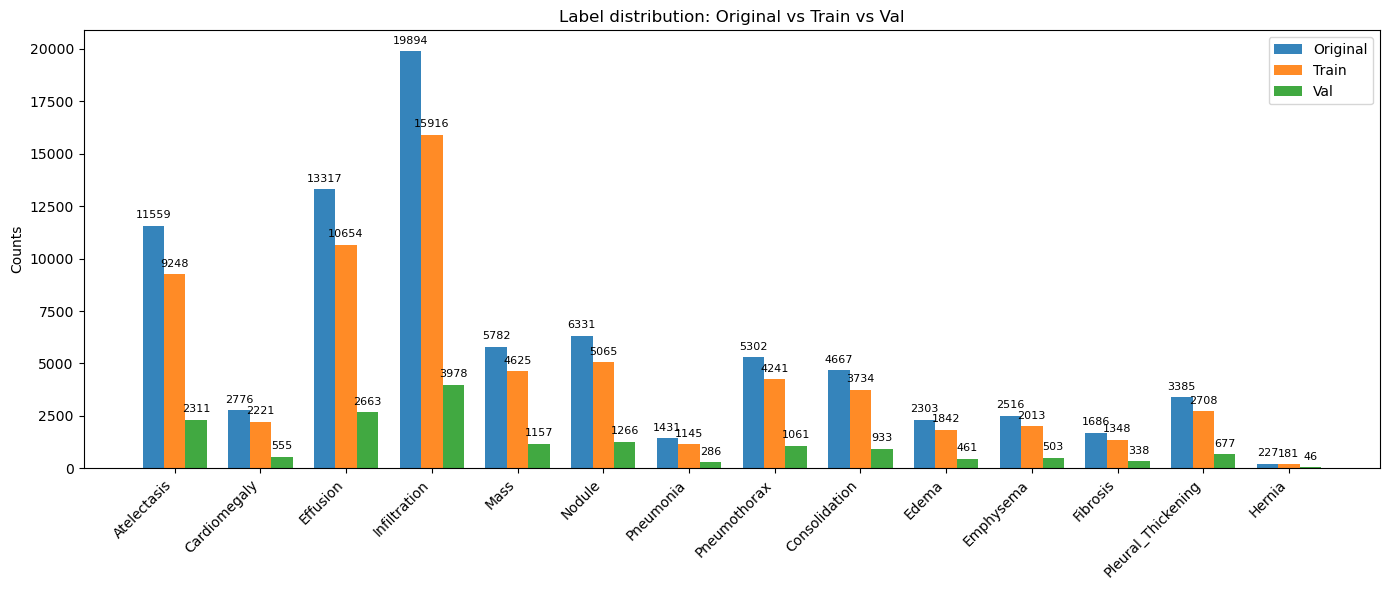

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple

def plot_multilabel_split_distribution(
    orig_df: pd.DataFrame,
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    label_columns: Optional[List[str]] = None,
    normalize: bool = False,
    figsize: Tuple[int,int] = (14,6),
    rotate_xticks: int = 45,
    title: str = "Label distribution: Original vs Train vs Val"
):
    """
    Plot side-by-side bar chart of counts (or percentages) for each label column
    in the original, train, and validation DataFrames.

    Args:
        orig_df, train_df, val_df: DataFrames that contain the binary label columns.
        label_columns: list of column names for labels. If None, attempt to infer
                       binary columns from orig_df (dtype numeric and values subset of {0,1}).
        normalize: if True, plot percentages (count / dataset_size * 100).
        figsize: figure size tuple.
        rotate_xticks: degrees to rotate class names.
        title: plot title.

    Returns:
        fig, ax : matplotlib Figure and Axes objects.
    """
    # infer label columns if not given
    if label_columns is None:
        cand = []
        for c in orig_df.columns:
            if pd.api.types.is_numeric_dtype(orig_df[c]):
                unique_vals = set(pd.Series(orig_df[c].dropna()).unique())
                # consider binary-ish numeric columns
                if unique_vals.issubset({0,1}) or unique_vals.issubset({0.0,1.0}):
                    cand.append(c)
        label_columns = cand
        if not label_columns:
            raise ValueError("Could not infer label columns. Please pass label_columns explicitly.")

    # compute counts
    orig_counts = orig_df[label_columns].sum(axis=0).astype(int)
    train_counts = train_df[label_columns].sum(axis=0).astype(int)
    val_counts   = val_df[label_columns].sum(axis=0).astype(int)

    # optionally normalize to percentages
    if normalize:
        orig_counts = 100.0 * orig_counts / len(orig_df)
        train_counts = 100.0 * train_counts / len(train_df)
        val_counts = 100.0 * val_counts / len(val_df)
        y_label = "Percentage (%)"
    else:
        y_label = "Counts"

    labels = label_columns
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=figsize)
    rects1 = ax.bar(x - width, orig_counts.values, width, label='Original', alpha=0.9)
    rects2 = ax.bar(x,           train_counts.values, width, label='Train', alpha=0.9)
    rects3 = ax.bar(x + width,   val_counts.values,   width, label='Val', alpha=0.9)

    # labels and cosmetics
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rotate_xticks, ha='right')
    ax.legend()

    # annotate bars with integer counts or formatted percentages
    def annotate_rects(rects, fmt="{:.0f}"):
        for r in rects:
            h = r.get_height()
            if np.isnan(h):
                s = "nan"
            else:
                s = fmt.format(h) if isinstance(h, (int, float, np.floating, np.integer)) else str(h)
            ax.annotate(s,
                        xy=(r.get_x() + r.get_width() / 2, h),
                        xytext=(0, 4),  # offset
                        textcoords="offset points",
                        ha="center", va="bottom", fontsize=8)

    if normalize:
        annotate_rects(rects1, fmt="{:.1f}")
        annotate_rects(rects2, fmt="{:.1f}")
        annotate_rects(rects3, fmt="{:.1f}")
    else:
        annotate_rects(rects1, fmt="{:.0f}")
        annotate_rects(rects2, fmt="{:.0f}")
        annotate_rects(rects3, fmt="{:.0f}")

    plt.tight_layout()
    return fig, ax

fig, ax = plot_multilabel_split_distribution(df, train_df, val_df, label_columns)


In [13]:
import pandas as pd

def multilabel_distribution_table(original_df, train_df, val_df, label_columns):    
    """Make a table showing the distribution is maintained.

    Args:
        original_df (dataframe): The original dataframe
        train_df (dataframe): The training dataframe
        val_df (dataframe): The validation dataframe
        label_columns (list): A list with the class names.

    Returns:
        Nothing: Displays the table
    """
    # Get the counts for each item in label colums
    original = original_df[label_columns].sum()
    train = train_df[label_columns].sum()
    val   = val_df[label_columns].sum()

    # Find the ratios by dividng the sum by the length
    orig_rate = original / len(original_df)
    train_rate = train / len(train_df)
    val_rate = val / len(val_df)

    # Make a simple dataframe with this info
    df = pd.DataFrame({
        "Orig_ratio": orig_rate,
        "Train_ratio": train_rate,
        "Val_ratio": val_rate,
        "Train-Orig": train_rate - orig_rate,
        "Val-Orig": val_rate - orig_rate,
    }).sort_index()

    # For readbility, make the ratio percentages 
    df[["Orig_ratio","Train_ratio","Val_ratio"]] *= 100
    df[["Train-Orig","Val-Orig"]] *= 100

    return df.round(3)

ratio_df = multilabel_distribution_table(df, train_df, val_df, label_columns)
ratio_df


,Orig_ratio,Train_ratio,Val_ratio,Train-Orig,Val-Orig
Atelectasis,10.309,10.310,10.306,0.001,-0.004
Cardiomegaly,2.476,2.476,2.475,0.000,-0.001
Consolidation,4.163,4.163,4.161,0.000,-0.002
Edema,2.054,2.054,2.056,-0.000,0.002
Effusion,11.877,11.878,11.876,0.000,-0.002
Emphysema,2.244,2.244,2.243,0.000,-0.001
Fibrosis,1.504,1.503,1.507,-0.001,0.004
Hernia,0.202,0.202,0.205,-0.001,0.003
Infiltration,17.743,17.744,17.740,0.001,-0.004
Mass,5.157,5.156,5.160,-0.001,0.003


Ok perfect, we can see through the chart and the dataframe above that the data has been split and the ratios are maintained fairly well.

In [14]:
import os

INPUT_DIR = r"C:\Users\aanta\Documents\ML\Projects\ChestXRays"
root = Path(r"C:\Users\aanta\Documents\ML\Projects\ChestXRays\kagglehub\data")

def get_image_path(filename):
    """Get the image path given a filename.

    Args:
        filename (str): The filename itself

    Raises:
        FileNotFoundError: Raise file not found error if the file does not exist

    Returns:
        candidate (str): The folder and filepath
    """
    for i in range(1, 13):
        folder = root / f"images_{i:03d}" / "images"
        candidate = folder / filename
        if candidate.exists():
            return str(candidate)
    raise FileNotFoundError(f"Image not found in any folder: {filename}")

In [15]:
def get_size(path):
    """The size of the file

    Args:
        path (str): The image path

    Returns:
        size: The size of the image at the given path
    """
    return Image.open(path).size

# Now we need to know the size of the images.  Let's test 500 images and get the sizes (meaning dimensions)
sizes = []
for i in range(500):
    filename = df.iloc[i]["Image Index"]
    path = get_image_path(filename)
    sizes.append(get_size(path))

Ok, so let's do a quick sanity check and verify that all 500 images in the above loop are the same size. I am going to resize to a specific size in the dataloader anyway but let's see what we are working with.

min/max/mean width: 1024 1024 1024.0
min/max/mean height: 1024 1024 1024.0
unique sizes count: 1


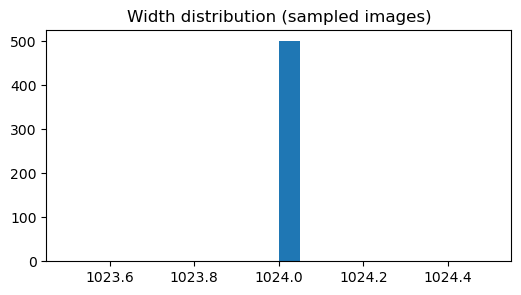

In [16]:
# Calculate the width and height
widths = [w for (w,h) in sizes]
heights = [h for (w,h) in sizes]

# Print what the mean width, height, and size count is
print("min/max/mean width:", np.min(widths), np.max(widths), np.mean(widths))
print("min/max/mean height:", np.min(heights), np.max(heights), np.mean(heights))
print("unique sizes count:", len(set(sizes)))

plt.figure(figsize=(6, 3))
plt.hist(widths, bins = 20)
plt.title("Width distribution (sampled images)")
plt.show()

# 4. Create Transforms for Data

Now that we have a better understanding of the data (shapes, class imbalances, evenly distributed them in train and test df, etc), we can start to build a Dataset, Transforms, and a DataLoader. 

In [17]:
def make_file_list(df_subset, label_cols):
    """Take the dataframe and split it into a structured list that can be used for a dataset.  It will contain the file paths and the associated label(s).

    Args:
        df_subset (dataframe): The dataframe containing the rows of data 
        label_cols (list[str]): List of columns names that represent the labels

    Returns:
        files (list[str]): The files themselves
        missing (list[str]: The files missing)
    """
    
    files = []
    missing = []
    
    for _, row in df_subset.iterrows():
        fname = row["Image Index"]
        try:
            path = get_image_path(fname)
        except FileNotFoundError:
            missing.append(fname)
            continue
        label_vec = row[label_cols].astype(float).tolist()
        files.append({"img": path, "label": label_vec})
    if missing:
        print(f"Warning: {len(missing)} missing images (first 5):", missing[:5])
    return files

In [18]:
# Make the train and test files
train_files = make_file_list(train_df, label_columns)
val_files = make_file_list(val_df, label_columns)

In [19]:
from monai.transforms import Compose, MapTransform
from monai.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch

from utils import custom_collate_fn

# 1. Define custom transforms
class LoadAndPreprocessImageD(MapTransform):
    """Load image, ensure grayscale, resize, and normalize"""
    def __init__(self, keys, image_size=224):
        super().__init__(keys)
        self.image_size = image_size
    
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            img_path = d[key]
            img = Image.open(img_path).convert("L")
            img = img.resize((self.image_size, self.image_size), Image.BILINEAR)
            img_array = np.array(img, dtype=np.float32) / 255.0
            img_array = img_array[np.newaxis, ...]
            d[key] = torch.from_numpy(img_array)
        return d

class RandomFlipD(MapTransform):
    """Random horizontal flip"""
    def __init__(self, keys, prob=0.5):
        super().__init__(keys)
        self.prob = prob
    
    def __call__(self, data):
        d = dict(data)
        if np.random.random() < self.prob:
            for key in self.keys:
                d[key] = torch.flip(d[key], dims=[2])
        return d

class LabelToTensorD(MapTransform):
    """Convert label list to tensor"""
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = torch.tensor(d[key], dtype=torch.float32)
        return d


In [ ]:
# 2. Create transforms
IMAGE_SIZE = 224

# Make the train and val transforms using the above custom transforms
train_transforms = Compose([
    LoadAndPreprocessImageD(keys=["img"], image_size=IMAGE_SIZE),
    RandomFlipD(keys=["img"], prob=0.5),
    LabelToTensorD(keys=["label"]),
])

val_transforms = Compose([
    LoadAndPreprocessImageD(keys=["img"], image_size=IMAGE_SIZE),
    LabelToTensorD(keys=["label"]),
])

# 3. Create monai atasets 
train_ds = Dataset(data=train_files, transform=train_transforms)
val_ds = Dataset(data=val_files, transform=val_transforms)

print(f"New datasets created: train={len(train_ds)}, val={len(val_ds)}")

# 4. Test a sample
test_sample = val_ds[0]
print(f"Test sample - img shape: {test_sample['img'].shape}, label shape: {test_sample['label'].shape}")

# 5. Create NEW dataloaders
BATCH_SIZE = 32

# Make the train and val dataloader
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

print(f"New dataloaders created: train batches={len(train_loader)}, val batches={len(val_loader)}")

New datasets created: train=89696, val=22424
Test sample - img shape: torch.Size([1, 224, 224]), label shape: torch.Size([14])
New dataloaders created: train batches=5606, val batches=1402


Now we have our Dataset, Transforms, and DataLoaders.  It is time to build the first model and transfer learn. 

Let's try densenet.  What is densenet? 

Densenet is a cnn that connects each layer to every other layer in a feed forward network.  This model alleviates vanishing gradient problems, strengthens feature propagation, encourages feature reuse, and sustainablly reduce the number of parameters.

In [21]:
from torchinfo import summary
import torchvision.models as models

def build_densenet(num_classes):
    """ Create a densenet for transfer learning.
    
    Args:
        num_classes (int): The number of classes for your project.

    Returns:
        model (torchvision.models): A PyTorch model
    """
    model = models.densenet121(weights = models.DenseNet121_Weights.DEFAULT) 
    
    num_ftrs = model.classifier.in_features
    print(f"Original input features to classifier: {num_ftrs}")
    
    model.classifier = nn.Linear(in_features = num_ftrs, 
                                 out_features = num_classes)
    
    print(f"New model output layer structure: {model.classifier}")

    for param in model.parameters():
        param.requires_grad = False 
        
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    
    return model

In [22]:
# Test the function works
densenet_model = build_densenet(num_classes = 14)
densenet_model = densenet_model.to("cuda")

Original input features to classifier: 1024
New model output layer structure: Linear(in_features=1024, out_features=14, bias=True)


In [23]:
summary(densenet_model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (9,408)
│    └─BatchNorm2d: 2-2                  (128)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             (45,440)
│    │    └─_DenseLayer: 3-2             (49,600)
│    │    └─_DenseLayer: 3-3             (53,760)
│    │    └─_DenseLayer: 3-4             (57,920)
│    │    └─_DenseLayer: 3-5             (62,080)
│    │    └─_DenseLayer: 3-6             (66,240)
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             (512)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (32,768)
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            (53,760)
│    │    └─

Ok now we have the model, let's set up the hyperparameters for training.

In [ ]:
import time 
import math 
import os 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.cuda.amp as amp 
import wandb 
from tqdm import tqdm 

# Set up Weights and Biases
PROJECT_NAME = "chesxray-wandb"
RUN_NAME = "densenet121-run1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training hyperparameters 
BATCH_SIZE = 32
NUM_WORKERS = 4 
IMAGE_SIZE = 224 
NUM_CLASSES = len(label_columns)
EPOCHS = 15 
LR = 1e-4 
WEIGHT_DECAY = 1e-5 
GRAD_ACCUM_STEPS = 1 
CLIP_GRAD_NORM = 1.0

# Checkpoint directory 
CKPT_DIR = "checkpoints" 
os.makedirs(CKPT_DIR, exist_ok = True)

# Initialize the Weights and Biases project
wandb.init(project=PROJECT_NAME, name = RUN_NAME, config = {
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE,
    "epochs": EPOCHS,
    "lr": LR, 
    "architecture": "densenet121",
    "num_classes": NUM_CLASSES
})

# Build model 0
model_0 = build_densenet(num_classes = NUM_CLASSES)
model_0 = model_0.to(DEVICE)

N = len(df) 

# This part is key, the dataset is multi label and very imbalanced.  Weighting will allow us to tell the loss function that rare positives are more important than abundant negatives.  
pos_weights = torch.tensor((N - class_counts) / class_counts, dtype=torch.float32).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights)
optimizer = torch.optim.Adam(model_0.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2, factor=0.5)


wandb: Currently logged in as: aantaki to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Original input features to classifier: 1024
New model output layer structure: Linear(in_features=1024, out_features=14, bias=True)


In [25]:
# We can see which classes are going to be emphasized more and it matches the ones with the least amount of data 
for name, w in zip(label_columns, pos_weights):
    print(name, float(w))


Atelectasis 8.699801445007324
Cardiomegaly 39.3890495300293
Effusion 7.419313430786133
Infiltration 4.635869979858398
Mass 18.39121437072754
Nodule 16.70968246459961
Pneumonia 77.3508071899414
Pneumothorax 20.14673614501953
Consolidation 23.023998260498047
Edema 47.684326171875
Emphysema 43.56279754638672
Fibrosis 65.50059509277344
Pleural_Thickening 32.12260055541992
Hernia 492.92071533203125


In [ ]:
import torch
from tqdm import tqdm
import time
import numpy as np

from utils import labels_to_tensor_on_device, validate_one_epoch

# Config 
EPOCHS = 12
GRAD_ACCUM_STEPS = 1
CLIP_NORM = 1.0

best_metric = 0.0

print("Training on device:", DEVICE)
print("Model param dtype:", next(model_0.parameters()).dtype)

# Training loop 
for epoch in range(1, EPOCHS + 1):
    # Step 0. Set model to train and 0 out variables
    model_0.train()
    epoch_loss = 0.0
    step = 0
    t0 = time.time()
    pbar = tqdm(train_loader, desc=f"Train {epoch}", leave=True)

    # Loop throgh each batch
    for batch in pbar:
        step += 1

        # 1) move and ensure fp32
        imgs = batch["img"].to(DEVICE, non_blocking=True).float()

        # 2) labels stable -> tensor on device
        labels = labels_to_tensor_on_device(batch["label"], imgs, DEVICE, NUM_CLASSES)

        # 3) repeat channel if model expects 3 channels
        try:
            conv_in_ch = next(model_0.parameters()).shape[1]
        except Exception:
            conv_in_ch = None
        if imgs.shape[1] == 1 and conv_in_ch == 3:
            imgs = imgs.repeat(1, 3, 1, 1)

        # 4) forward/backward in fp32
        optimizer.zero_grad()
        try:
            # Forward pass, calculate loss, loss backward
            logits = model_0(imgs)                 # fp32 forward
            loss = criterion(logits, labels) / GRAD_ACCUM_STEPS
            loss.backward()
            # accumulate / step
            if (step % GRAD_ACCUM_STEPS) == 0:
                torch.nn.utils.clip_grad_norm_(model_0.parameters(), CLIP_NORM)
                optimizer.step()
                optimizer.zero_grad()
        
        # Proactively catch memory errors
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print("CUDA OOM encountered. Clearing cache and retrying once.")
                torch.cuda.empty_cache()
                try:
                    # Do the forward passs, calculate loss, and loss backward again after clearing out the memory cache
                    logits = model_0(imgs)
                    loss = criterion(logits, labels) / GRAD_ACCUM_STEPS
                    loss.backward()
                    if (step % GRAD_ACCUM_STEPS) == 0:
                        torch.nn.utils.clip_grad_norm_(model_0.parameters(), CLIP_NORM)
                        optimizer.step()
                        optimizer.zero_grad()
                except RuntimeError:
                    print("Retry failed. Consider reducing BATCH_SIZE or IMAGE_SIZE.")
                    raise
            else:
                raise

        # Upldate total loss for the each epoch 
        epoch_loss += (loss.item() * GRAD_ACCUM_STEPS) * imgs.size(0)
        pbar.set_postfix({"loss": f"{(epoch_loss / ((step) * imgs.size(0))):.4f}"})

    # Calcualte total loss each epoch
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_time = time.time() - t0

    # Caluclate the val metrics and write the details to the screen 
    val_metric, per_class_auroc, _, _ = validate_one_epoch(model_0, val_loader)
    print(f"Epoch {epoch} time {epoch_time:.1f}s train_loss {epoch_loss:.4f} val_macro_auroc {val_metric:.4f}")
    
    
    # Log to W&B
    log_dict = {
        "epoch": epoch + 1,
        "epoch loss": epoch_loss,
        "val/macro_auroc": val_metric,
        "epoch time": epoch_time,
        "per_class_auroc": per_class_auroc,
        "learning_rate": LR,
        "epoch_time": epoch_time,
        }

    # scheduler & checkpoint
    try:
        scheduler.step(val_metric)
    except Exception:
        pass

    # Quick test to see if the val_metric is better than the current best one which is 0 by defualt.  Save the model if it is.
    if val_metric > best_metric:
        best_metric = val_metric
        ckpt_path = f"best_model_epoch{epoch}_auc{best_metric:.4f}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model_0.state_dict(),
            "opt_state": optimizer.state_dict(),
            "best_metric": best_metric
        }, ckpt_path)
        print("Saved best model to", ckpt_path)
        
    wandb.log(log_dict)

print("Training finished.")
wandb.finish()

Training on device: cuda
Model param dtype: torch.float32


val: 100%|██████████| 1402/1402 [05:56<00:00,  3.93it/s]


Epoch 1 time 1585.6s train_loss 1.3429 val_macro_auroc 0.7100
Saved best model to best_model_epoch1_auc0.7100.pth


val: 100%|██████████| 1402/1402 [06:08<00:00,  3.81it/s]


Epoch 2 time 1568.4s train_loss 1.2732 val_macro_auroc 0.7267
Saved best model to best_model_epoch2_auc0.7267.pth


val: 100%|██████████| 1402/1402 [06:03<00:00,  3.86it/s]


Epoch 3 time 1520.8s train_loss 1.2470 val_macro_auroc 0.7330
Saved best model to best_model_epoch3_auc0.7330.pth


val: 100%|██████████| 1402/1402 [06:02<00:00,  3.87it/s]


Epoch 4 time 1613.5s train_loss 1.2285 val_macro_auroc 0.7371
Saved best model to best_model_epoch4_auc0.7371.pth


val: 100%|██████████| 1402/1402 [06:00<00:00,  3.89it/s]


Epoch 5 time 1591.1s train_loss 1.2226 val_macro_auroc 0.7389
Saved best model to best_model_epoch5_auc0.7389.pth


val: 100%|██████████| 1402/1402 [06:24<00:00,  3.64it/s]


Epoch 6 time 1647.2s train_loss 1.2086 val_macro_auroc 0.7412
Saved best model to best_model_epoch6_auc0.7412.pth


val: 100%|██████████| 1402/1402 [06:12<00:00,  3.76it/s]


Epoch 7 time 1635.8s train_loss 1.2067 val_macro_auroc 0.7429
Saved best model to best_model_epoch7_auc0.7429.pth


val: 100%|██████████| 1402/1402 [06:31<00:00,  3.58it/s]


Epoch 8 time 1672.8s train_loss 1.1986 val_macro_auroc 0.7442
Saved best model to best_model_epoch8_auc0.7442.pth


val: 100%|██████████| 1402/1402 [06:53<00:00,  3.39it/s]


Epoch 9 time 1691.7s train_loss 1.2000 val_macro_auroc 0.7447
Saved best model to best_model_epoch9_auc0.7447.pth


val: 100%|██████████| 1402/1402 [06:34<00:00,  3.55it/s]


Epoch 10 time 1690.4s train_loss 1.1918 val_macro_auroc 0.7452
Saved best model to best_model_epoch10_auc0.7452.pth


val: 100%|██████████| 1402/1402 [06:24<00:00,  3.65it/s]


Epoch 11 time 1695.6s train_loss 1.1927 val_macro_auroc 0.7469
Saved best model to best_model_epoch11_auc0.7469.pth


val: 100%|██████████| 1402/1402 [06:19<00:00,  3.69it/s]


Epoch 12 time 1667.6s train_loss 1.1807 val_macro_auroc 0.7469
Saved best model to best_model_epoch12_auc0.7469.pth
Training finished.


In [ ]:
from torchinfo import summary
import torchvision.models as models

def build_effnetb2(num_classes):
    """
    Create an effnetb2 for transfer learning.
    
    Args:
        num_classes (int): The number of classes for your project.

    Returns:
        model (torchvision.models): A PyTorch model
    """
    model = models.efficientnet_b2(weights = models.EfficientNet_B2_Weights.DEFAULT) 
    
    # Get the input to the last layer so we know how to change the classifier 
    num_ftrs = model.classifier[1].in_features
    print(f"Original input features to classifier: {num_ftrs}")
    
    # Adjust classifier with input feautres and num classes as output
    model.classifier = nn.Linear(in_features = num_ftrs, 
                                 out_features = num_classes)
    
    print(f"New model output layer structure: {model.classifier}")

    # Freeze the model 
    for param in model.parameters():
        param.requires_grad = False 
        
    # Unfreeze the classifier so trianing updates it
    for param in model.classifier.parameters():
        param.requires_grad = True
        
    
    return model

In [21]:
effnetb2_model = build_effnetb2(num_classes = 14)
effnetb2_model

Original input features to classifier: 1408
New model output layer structure: Linear(in_features=1408, out_features=14, bias=True)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
import time 
import math 
import os 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.cuda.amp as amp 
import wandb 
from tqdm import tqdm 

PROJECT_NAME = "chesxray-wandb"
RUN_NAME = "effnetb2-run1"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training hyperparameters 
BATCH_SIZE = 32
NUM_WORKERS = 4 
IMAGE_SIZE = 224 
NUM_CLASSES = len(label_columns)
EPOCHS = 15 
LR = 1e-4 
WEIGHT_DECAY = 1e-5 
GRAD_ACCUM_STEPS = 1 
CLIP_GRAD_NORM = 1.0

# CHeckpoint directory 
CKPT_DIR = "checkpoints" 
os.makedirs(CKPT_DIR, exist_ok = True)

# Make a Weights and Biases project if not done already
wandb.init(project=PROJECT_NAME, name = RUN_NAME, config = {
    "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE,
    "epochs": EPOCHS,
    "lr": LR, 
    "architecture": "effnetb2",
    "num_classes": NUM_CLASSES
})

# Build effnet
model_1 = build_effnetb2(num_classes = NUM_CLASSES)
model_1 = model_1.to(DEVICE)

N = len(df)

# This part is key, the dataset is multi label and very imbalanced.  Weighting will allow us to tell the loss function that rare positives are more important than abundant negatives.  
pos_weights_effnetb2 = torch.tensor((N - class_counts) / class_counts, dtype=torch.float32).to(DEVICE)

criterion_effnetb2 = torch.nn.BCEWithLogitsLoss(pos_weight = pos_weights_effnetb2)
optimizer_effnetb2 = torch.optim.Adam(model_1.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
scheduler_effnetb2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_effnetb2, mode="max", patience=2, factor=0.5)

wandb: Currently logged in as: aantaki to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Original input features to classifier: 1408
New model output layer structure: Linear(in_features=1408, out_features=14, bias=True)


In [ ]:
from monai.transforms import Compose, MapTransform
from monai.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch

IMAGE_SIZE = 224

# Create train and val transforms for effnet model 
train_transforms_effnetb2 = Compose([
    LoadAndPreprocessImageD(keys=["img"], image_size=IMAGE_SIZE),
    RandomFlipD(keys=["img"], prob=0.5),
    LabelToTensorD(keys=["label"]),
])

val_transforms_effnetb2 = Compose([
    LoadAndPreprocessImageD(keys=["img"], image_size=IMAGE_SIZE),
    LabelToTensorD(keys=["label"]),
])

# Create NEW datasets with NEW names for EffnetB2 (same process as the densenet but change the names for effnet) 
train_ds_effnetb2 = Dataset(data=train_files, transform=train_transforms_effnetb2)
val_ds_effnetb2 = Dataset(data=val_files, transform=val_transforms_effnetb2)

print(f"New datasets created: train={len(train_ds_effnetb2)}, val={len(val_ds_effnetb2)}")

# Test a sample
test_sample = val_ds_effnetb2[0]
print(f"Test sample - img shape: {test_sample['img'].shape}, label shape: {test_sample['label'].shape}")

# 5. Create NEW dataloaders
BATCH_SIZE = 32

# Create train and val dataloaders for effnet
train_loader_effnetb2 = DataLoader(
    train_ds_effnetb2, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

val_loader_effnetb2 = DataLoader(
    val_ds_effnetb2, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

print(f"New dataloaders created: train batches={len(train_loader_effnetb2)}, val batches={len(val_loader_effnetb2)}")

New datasets created: train=89696, val=22424
Test sample - img shape: torch.Size([1, 224, 224]), label shape: torch.Size([14])
New dataloaders created: train batches=5606, val batches=1402


In [24]:
import torch
from tqdm import tqdm
import time
import numpy as np

from utils import labels_to_tensor_on_device, validate_one_epoch

# Config 
EPOCHS = 12
GRAD_ACCUM_STEPS = 1
CLIP_NORM = 1.0

best_metric = 0.0

print("Training on device:", DEVICE)
print("Model param dtype:", next(model_1.parameters()).dtype)

# Training loop
for epoch in range(1, EPOCHS + 1):
    # Set model to train and 0 out variables
    model_1.train()
    epoch_loss = 0.0
    step = 0
    t0 = time.time()
    pbar = tqdm(train_loader_effnetb2, desc=f"Train {epoch}", leave=True)

    # Loop through each batch 
    for batch in pbar:
        step += 1

        # 1) move and ensure fp32
        imgs = batch["img"].to(DEVICE, non_blocking=True).float()

        # 2) labels stable -> tensor on device
        labels = labels_to_tensor_on_device(batch["label"], imgs, DEVICE, NUM_CLASSES)

        # 3) repeat channel if model expects 3 channels
        try:
            conv_in_ch = next(model_1.parameters()).shape[1]
        except Exception:
            conv_in_ch = None
        if imgs.shape[1] == 1 and conv_in_ch == 3:
            imgs = imgs.repeat(1, 3, 1, 1)

        # 4) Zero out optimizer and do forward pass, calculate loss, and loss backward
        optimizer_effnetb2.zero_grad()
        try:
            logits = model_1(imgs)                 # fp32 forward
            loss = criterion_effnetb2(logits, labels) / GRAD_ACCUM_STEPS
            loss.backward()
            # accumulate / step
            if (step % GRAD_ACCUM_STEPS) == 0:
                torch.nn.utils.clip_grad_norm_(model_1.parameters(), CLIP_NORM)
                optimizer_effnetb2.step()
                optimizer_effnetb2.zero_grad()
        # Proactively catch memory issues
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print("CUDA OOM encountered. Clearing cache and retrying once.")
                torch.cuda.empty_cache()
                try:
                    # Try forward pass, calculate loss, and loss backward again after clearing out memory cache
                    logits = model_1(imgs)
                    loss = criterion_effnetb2(logits, labels) / GRAD_ACCUM_STEPS
                    loss.backward()
                    if (step % GRAD_ACCUM_STEPS) == 0:
                        torch.nn.utils.clip_grad_norm_(model_0.parameters(), CLIP_NORM)
                        optimizer_effnetb2.step()
                        optimizer_effnetb2.zero_grad()
                except RuntimeError:
                    print("Retry failed. Consider reducing BATCH_SIZE or IMAGE_SIZE.")
                    raise
            else:
                raise

        # Sum total loss at the end of each epoch
        epoch_loss += (loss.item() * GRAD_ACCUM_STEPS) * imgs.size(0)
        pbar.set_postfix({"loss": f"{(epoch_loss / ((step) * imgs.size(0))):.4f}"})

    # Calculate the loss for the epoch
    epoch_loss = epoch_loss / len(train_loader_effnetb2.dataset)
    epoch_time = time.time() - t0

    # Calculate the valualtion metrics
    val_metric, per_class_auroc, _, _ = validate_one_epoch(model_1, val_loader_effnetb2)
    print(f"Epoch {epoch} time {epoch_time:.1f}s train_loss {epoch_loss:.4f} val_macro_auroc {val_metric:.4f}")
    
    
    # Log to W&B
    log_dict = {
        "epoch": epoch + 1,
        "epoch loss": epoch_loss,
        "val/macro_auroc": val_metric,
        "epoch time": epoch_time,
        "per_class_auroc": per_class_auroc,
        "learning_rate": LR,
        "epoch_time": epoch_time,
        }

    # scheduler & checkpoint
    try:
        scheduler.step(val_metric)
    except Exception:
        pass

    # Save best model if it beat the best metric 
    if val_metric > best_metric:
        best_metric = val_metric
        ckpt_path = f"best_model_epoch{epoch}_auc{best_metric:.4f}.pth"
        torch.save({
            "epoch": epoch,
            "model_state": model_1.state_dict(),
            "opt_state": optimizer_effnetb2.state_dict(),
            "best_metric": best_metric
        }, ckpt_path)
        print("Saved best model to", ckpt_path)
        
    wandb.log(log_dict)

print("Training finished.")
wandb.finish()


Training on device: cuda
Model param dtype: torch.float32


val: 100%|██████████| 1402/1402 [06:00<00:00,  3.89it/s]


Epoch 1 time 1564.7s train_loss 1.3207 val_macro_auroc 0.7121
Saved best model to best_model_epoch1_auc0.7121.pth


val: 100%|██████████| 1402/1402 [05:50<00:00,  4.00it/s]


Epoch 2 time 1563.2s train_loss 1.2691 val_macro_auroc 0.7285
Saved best model to best_model_epoch2_auc0.7285.pth


val: 100%|██████████| 1402/1402 [06:06<00:00,  3.83it/s]


Epoch 3 time 1593.1s train_loss 1.2378 val_macro_auroc 0.7351
Saved best model to best_model_epoch3_auc0.7351.pth


val: 100%|██████████| 1402/1402 [06:18<00:00,  3.71it/s]


Epoch 4 time 1609.0s train_loss 1.2235 val_macro_auroc 0.7385
Saved best model to best_model_epoch4_auc0.7385.pth


val: 100%|██████████| 1402/1402 [06:05<00:00,  3.84it/s]


Epoch 5 time 1658.1s train_loss 1.2173 val_macro_auroc 0.7406
Saved best model to best_model_epoch5_auc0.7406.pth


val: 100%|██████████| 1402/1402 [09:31<00:00,  2.45it/s]


Epoch 6 time 2233.9s train_loss 1.2149 val_macro_auroc 0.7437
Saved best model to best_model_epoch6_auc0.7437.pth


val: 100%|██████████| 1402/1402 [05:56<00:00,  3.93it/s]


Epoch 7 time 1574.8s train_loss 1.2040 val_macro_auroc 0.7432


val: 100%|██████████| 1402/1402 [05:54<00:00,  3.95it/s]


Epoch 8 time 1611.7s train_loss 1.2021 val_macro_auroc 0.7451
Saved best model to best_model_epoch8_auc0.7451.pth


val: 100%|██████████| 1402/1402 [05:53<00:00,  3.96it/s]


Epoch 9 time 1547.6s train_loss 1.1861 val_macro_auroc 0.7463
Saved best model to best_model_epoch9_auc0.7463.pth


val: 100%|██████████| 1402/1402 [05:48<00:00,  4.03it/s]


Epoch 10 time 1522.6s train_loss 1.1808 val_macro_auroc 0.7469
Saved best model to best_model_epoch10_auc0.7469.pth


val: 100%|██████████| 1402/1402 [05:50<00:00,  4.00it/s]


Epoch 11 time 1519.1s train_loss 1.1773 val_macro_auroc 0.7473
Saved best model to best_model_epoch11_auc0.7473.pth


val: 100%|██████████| 1402/1402 [05:43<00:00,  4.08it/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 12 time 1513.3s train_loss 1.1768 val_macro_auroc 0.7480
Saved best model to best_model_epoch12_auc0.7480.pth
Training finished.


epoch,▁▂▂▃▄▄▅▅▆▇▇█
epoch loss,█▅▄▃▃▃▂▂▁▁▁▁
epoch time,▁▁▂▂▂█▂▂▁▁▁▁
epoch_time,▁▁▂▂▂█▂▂▁▁▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
val/macro_auroc,▁▄▅▆▇▇▇▇████
epoch,13
epoch loss,1.17682
epoch time,1513.34738
epoch_time,1513.34738
learning_rate,0.0001
